

In your project, you will pick a dataset (time-series) and an associated problem that can be solved via sequence models. You must describe why you need sequence models to solve this problem. Include a link to the dataset source. Next, you should pick an RNN framework that you would use to solve this problem (This framework can be in TensorFlow, PyTorch or any other Python Package).

For this problem, I will use the Ethereum-USD exchange rate data. This dataset contains the price of Etherum crypto-currency in a 1-minute interval. It contains information about market data relate to the currency, such as open, high, low and trade volume during the minute marker.

The dataset can be accessed in:

https://www.kaggle.com/datasets/patrickgendotti/btc-and-eth-1min-price-history


In [1]:
# same deal for gdrive and kaggle
from google.colab import drive
drive.mount('/content/drive')

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/.kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle


# download 

Mounted at /content/drive
rm: cannot remove '/root/.kaggle': No such file or directory


In [2]:
# install dataset and unzip

!rm -r dataset
!kaggle datasets download -d patrickgendotti/btc-and-eth-1min-price-history
!mkdir dataset
!unzip btc-and-eth-1min-price-history.zip -d dataset

rm: cannot remove 'dataset': No such file or directory
 99% 117M/118M [00:01<00:00, 124MB/s]
100% 118M/118M [00:01<00:00, 116MB/s]
Archive:  btc-and-eth-1min-price-history.zip
  inflating: dataset/ETH_1min.csv    
  inflating: dataset/coinbaseUSD_1-min_data.csv  


In [ ]:
!pip install livelossplot -q

In [3]:
import pandas as pd


raw_data = pd.read_csv('dataset/ETH_1min.csv')
raw_data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1462800720,2016-05-09 13:32:00+00:00,ETH-USD,0.0,12.0,0.0,12.0,4.156276
1,1462800780,2016-05-09 13:33:00+00:00,ETH-USD,12.0,12.0,10.0,10.0,43.497506
2,1462800840,2016-05-09 13:34:00+00:00,ETH-USD,10.0,10.0,10.0,10.0,8.000000
3,1462800900,2016-05-09 13:35:00+00:00,ETH-USD,10.0,10.0,10.0,10.0,60.000000
4,1462800960,2016-05-09 13:36:00+00:00,ETH-USD,10.0,10.0,10.0,10.0,0.375000


In [4]:
# its probably sorted, but just to make sure
raw_data = raw_data.sort_values(by=['Unix Timestamp'])
# we don't need the date or symbol
raw_data = raw_data.drop(['Date','Symbol','Unix Timestamp'],axis=1)

In [5]:
# target variable is "Close", which is the closing price. So we will move it to the back
raw_data = raw_data[[c for c in raw_data.columns if not c == 'Close'] + ['Close']]
display(raw_data.describe())

# print(X_raw.shape)

,Open,High,Low,Volume,Close
count,3.054062e+06,3.054062e+06,3.054062e+06,3.054062e+06,3.054062e+06
mean,8.450225e+02,8.456590e+02,8.443716e+02,7.264365e+01,8.450248e+02
std,1.177972e+03,1.178885e+03,1.177041e+03,4.001419e+02,1.177974e+03
min,0.000000e+00,5.990000e+00,0.000000e+00,0.000000e+00,5.990000e+00
25%,1.446600e+02,1.447000e+02,1.446100e+02,0.000000e+00,1.446600e+02
50%,2.790100e+02,2.791300e+02,2.789300e+02,6.771819e+00,2.790100e+02
75%,8.549675e+02,8.551875e+02,8.545000e+02,6.753221e+01,8.549775e+02
max,4.864970e+03,4.867810e+03,4.863000e+03,2.764235e+05,4.864970e+03


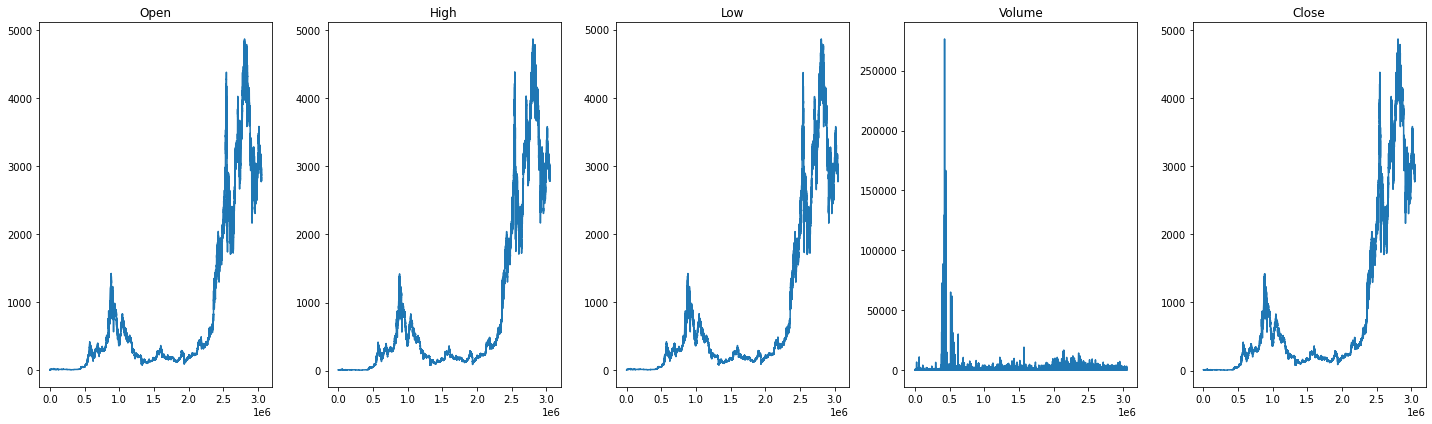

In [6]:
# examining feature distribution

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# numerical = X_raw.columns[X_raw.dtypes.isin([int,float])]
# numerical = dataset.select_dtypes(exclude=['object','bool'])
# X_raw.dtypes

fig,axes = plt.subplots(ncols=raw_data.shape[1],figsize=(raw_data.shape[1] * 4,6))

for c,ax in zip(raw_data.columns,axes):
    raw_data[c].plot(ax=ax,title=c)
    # sns.lineplot(data=X_raw[c],ax=ax)


fig.tight_layout()

In [7]:
for c in raw_data.columns:
    print(f'Feature: {c} -- {raw_data[c].isna().sum()/raw_data.shape[0] * 100 :.4f}% values are NA')

Feature: Open -- 0.0000% values are NA
Feature: High -- 0.0000% values are NA
Feature: Low -- 0.0000% values are NA
Feature: Volume -- 0.0000% values are NA
Feature: Close -- 0.0000% values are NA


as expected, open/high/low follow a pattern. Volume seems to die down as time goes. To check if the High/Low interval changes, I will add a new column

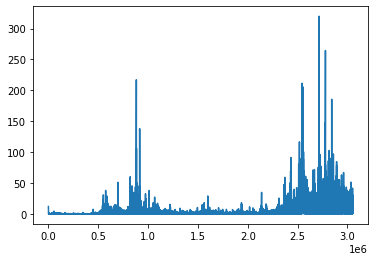

In [8]:
raw_data['Delta'] = raw_data['High'] - raw_data['Low']

raw_data['Delta'].plot()

Delta looks like it also carries some information! We will keep this feature in the dataset

In [109]:
# preprocessing the dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
import numpy as np

from torch import tensor

np.random.seed(0)

# split needs to happen before normalization

# 8: 1: 1 for train: dev: test
train_data,test_data = train_test_split(raw_data,test_size=0.1,random_state=0)
train_data,dev_data = train_test_split(train_data,test_size=0.1 / 0.9,random_state=0)

# since some columns of the dataset are categorical variables, we need to encode them somehow for the NN

# handle numeric features
# fill nan values with median values and also scale
numeric_transformer = Pipeline(
    steps=[("standard_scaler", StandardScaler()),('minmax_scaler',MinMaxScaler())]
)


# processed_data = preprocessor.fit_transform(raw_data)

# the dataset is huge, so we will load the original version to cuda first, so that we can simply slice out what we need
train_data = tensor(train_data.values).float().cuda()
dev_data = tensor(dev_data.values).float().cuda()
test_data = tensor(test_data.values).float().cuda()


In [110]:
train_data.shape, dev_data.shape,test_data.shape

(torch.Size([2443248, 6]), torch.Size([305407, 6]), torch.Size([305407, 6]))

In [111]:
# To prepare the data for our models, need to create a dataset and loader

import torch
from torch.utils.data import DataLoader,Dataset

class ETHData(Dataset):
    def __init__(self,data,bin_size=100):
        # self.data = data

        # X,y = [],[]
        self.X = torch.stack([ data[i:i+bin_size,:] for i in range(data.size(0) - bin_size) ])
        self.y = data[bin_size:,-1]
    def __len__(self,):
        return self.y.size(0)
    
    def __getitem__(self,idx):
        return (
            # notice that we are including past 'Close' column into the input data as well
            self.X[idx],
            self.y[idx]
        )

# train_data = ETHData(train_data)
# dev_data = ETHData(dev_data)
# test_data = ETHData(test_data)

In [112]:
dd = ETHData(train_data)

In [114]:
model(dd.X)

RuntimeError: ignored

In [57]:
from torch import nn,optim
from livelossplot import PlotLosses
from tqdm.auto import tqdm
from sklearn.metrics import r2_score,mean_squared_error

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bin_size =100):
        super(RNN, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_size = hidden_size
        
        # Number of hidden layers
        self.num_layers = num_layers
        
        # RNN https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu')
        self.out_layer = nn.Linear(hidden_size, 1)


        # self.loss_func = nn.MSELoss()
    
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.out_layer(out[:, -1, :]) 
        return out[:,0]

    def train(
        self,
        train_data,
        dev_data,
        num_epoch=100,
        lr=1e-4,
        wd=1e-3,
        loss_func=nn.MSELoss,
        extra_metrics=[r2_score,mean_squared_error]
    ):
        train_loader = DataLoader(ETHData(train_data,bin_size=100),batch_size=512,shuffle=False)
        dev_dset = ETHData(dev_data,bin_size=100)

        optimizer = optim.Adam(self.parameters(), lr=lr,weight_decay=wd)
        criterion = loss_func()


        liveloss = PlotLosses()

        for _ in range(num_epoch):
            all_losses = []
            y_real_train = []
            y_pred_train = []
            for x,y in tqdm(train_loader, desc='going through batches...',leave=False):
                optimizer.zero_grad()
                pred = self.forward(x)
                loss = criterion(pred,y)
                loss.backward()
                optimizer.step()

                all_losses.append(loss.item())
                y_real_train.append(y)
                y_pred_train.append(pred)
            
            all_real_train,all_pred_train = torch.hstack(y_real_train).cpu(),torch.hstack(y_pred_train).cpu()

            all_real_dev = dev_dset.y.cpu()
            all_pred_dev = self.predict(dev_dset.X).cpu()
            
            liveloss.update(dict(
                [
                    (loss_func.__name__, np.mean(all_losses))
                ] + [
                    (f'{m.__name__}_train',m(all_real_train,all_pred_train))
                    for m in extra_metrics
                ]
            ))
            liveloss.send()

    @torch.no_grad()
    def predict(self, X_input):
        return self.forward(X_input)
    
    @torch.no_grad()
    def score(self, X_input, y_input, metrics = [r2_score] ):
        pred = self.predict(X_input).cpu()
        return {
            m.__name__: m(y_input,pred)
            for m in metrics
        }




    

    

In [89]:
# dev_loader = DataLoader(ETHData(dev_data,bin_size=100),batch_size=dev_data.size(0),shuffle=False)

# for x,y in dev_loader: break

# model(dev_loader.get(0))
# dev_data.size(0),dev_data.shape

X_dev,y_dev = zip(*[(x,y) for x,y in ETHData(dev_data,bin_size=100)])
X_dev = torch.stack(X_dev)
y_dev = torch.hstack(y_dev)

In [94]:
# torch.(X_dev)
# len(train_loader.dataset)
torch.hstack(y_dev)

tensor([0.1900, 0.3000, 7.7600,  ..., 0.3700, 1.4700, 0.9000], device='cuda:0')

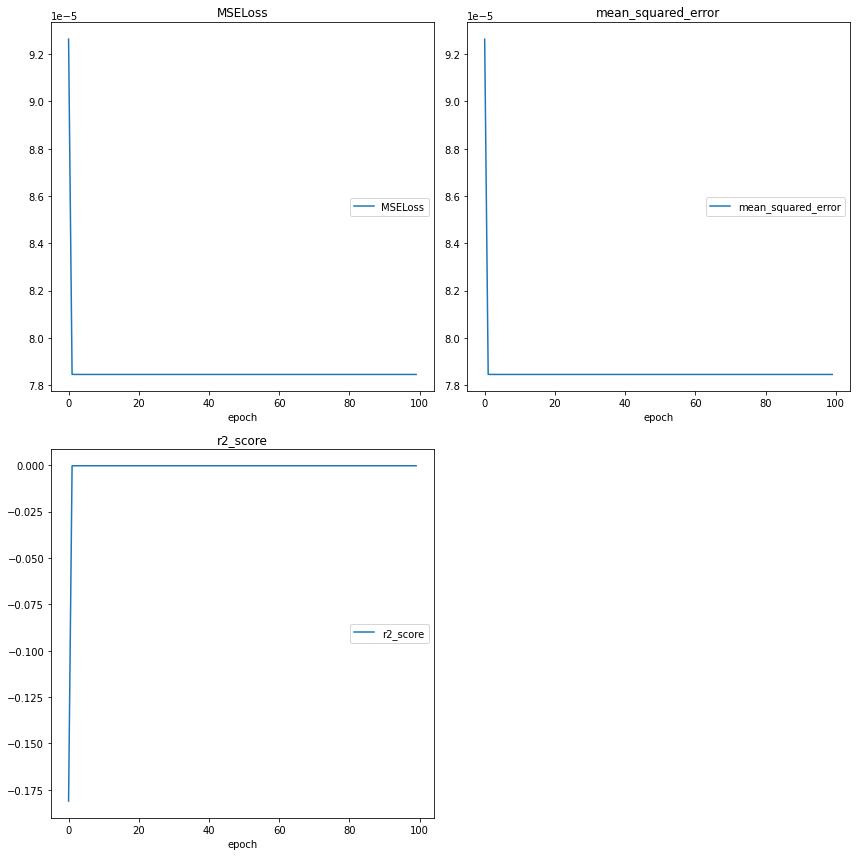

MSELoss
	MSELoss          	 (min:    0.000, max:    0.000, cur:    0.000)
mean_squared_error
	mean_squared_error 	 (min:    0.000, max:    0.000, cur:    0.000)
r2_score
	r2_score         	 (min:   -0.181, max:   -0.000, cur:   -0.000)


In [51]:
model = RNN(6,10,1).cuda()
model.train(train_data,dev_data,num_epoch=100)


## Task 1 (60 points):
### Part 1 (30 points): 
Implement your RNN either using an existing framework OR you can implement your own RNN cell structure. In either case, describe the structure of your RNN and the activation functions you are using for each time step and in the output layer. Define a metric you will use to measure the performance of your model 

NOTE: Performance should be measured both for the validation set and the test set.

### Part 2 (35 points): 
Update your network from part 1 with first an LSTM and then a GRU based cell structure (You can treat both as 2 separate implementations). Re-do the training and performance evaluation. What are the major differences you notice? Why do you think those differences exist between the 3 implementations (basic RNN, LSTM and GRU)?

Note: In part 1 and 2, you must perform sufficient data-visualization, pre-processing and/or feature-engineering if needed. The overall performance visualization of the loss function should also be provided.

### Part 3 (10 points): 
Can you use the traditional feed-forward network to solve the same problem. Why or why not? 

Hint: Can time series data be converted to usual features that can be used as input to a feed-forward network?


## Task 2 (25 points): 
In this task, use any of the pre-trained word embeddings. The Wor2vec embedding link provided with the lecture notes can be useful to get started. Write your own code/function that Projects in Machine Learning and AI (RPI Fall 2022) uses these embeddings and outputs cosine similarity and a dissimilarity score for any 2 pair of words (read as user input). The dissimilarity score should be defined by you. You either can have your own idea of a dissimilarity score or refer to literature (cite the paper you used). In 
either case clearly describe how this score helps determine the dissimilarity between 2 words.

Note: Dissimilarity measure has been an important metric for recommender systems trying to introduce ‘Novelty and Diversity’ in assortments (as opposed to only accuracy). You might find different metrics of dissimilarity in recommender system’s literature